In [1]:
import pandas as pd
import numpy as np
import gdown 
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sps

# Разведочный анализ данных 
## Описание данных

**Данные состоят из 2 [файлов](https://drive.google.com/drive/folders/1Z8uIxxGSSsER22x4Uh546jXuE8NUIUNz?usp=sharing):**
* *products.csv*  - товары с их харакретистиками
* *transactions.csv*  - транзакции покупателей

**products.csv** 49688 строк
* *product_id* : int - уникальный идентификатор товара
* *product_name* : str - название товара
* *aisle_id* : int - уникальный идентификатор подкатегории
* *department_id* : int - уникальный идентификатор категории
* *aisle* : str - название подкатегории
* *department* : str - название категории

**transactions.csv** 26408073 строк
* *order_id* : int - уникальный идентификатор транзакции
* *user_id* : int - уникальный идентификатор покупателя
* *order_number* : int - номер транзакции в истории покупок данного пользователя
* *order_dow* : int - день недели транзакции
* *order_hour_of_day* : int - час совершения транзакции
* *days_since_prior_order* : float (1045204 None)- количество дней с совершения предыдущей транзакции данным пользователем
* *product_id* : int - уникальный идентификатор товара
* *add_to_cart_order* : float - номер под которым данный товар был добавлен в корзину
* *reordered* : float - был ли товар "перезаказан"

## План последующей работы:

* Этап 1: Разведочный анализ данных (EDA);
* Этап 2: Выбор классического метода ML, обучение, оценка (колаборативная фильтрация и PureSVD);
* Этап 3: Применение нейросетевых подходов (DL), обучение модели, оценка;
* Этап 4: Разработка веб-сервиса.


<b>Загрузка данных</b>

In [2]:
def get_df_from_file(url: str, name_file: str):
    gdown.download(url, name_file, quiet=False)
    df = pd.read_csv(name_file)
    return df

In [3]:
# Загрузка датасета с продуктами
product_df = get_df_from_file(url='https://drive.google.com/uc?export=download&id=1cXQdWRMbuMqcxWwwifP7tK6GuYWuSPd0', 
                              name_file='products.csv')
# product_df = pd.read_csv('products.csv')

Downloading...
From: https://drive.google.com/uc?export=download&id=1cXQdWRMbuMqcxWwwifP7tK6GuYWuSPd0
To: c:\code\rec_sys\hse_mlds_recsys_project\EDA\products.csv
100%|██████████| 3.40M/3.40M [00:00<00:00, 5.12MB/s]


In [4]:
product_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49688 entries, 0 to 49687
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   product_id     49688 non-null  int64 
 1   product_name   49688 non-null  object
 2   aisle_id       49688 non-null  int64 
 3   department_id  49688 non-null  int64 
 4   aisle          49688 non-null  object
 5   department     49688 non-null  object
dtypes: int64(3), object(3)
memory usage: 2.3+ MB


In [5]:
product_df.describe(include='all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
product_id,49688.0,NaN,NaN,NaN,24844.5,14343.834425,1.0,12422.75,24844.5,37266.25,49688.0
product_name,49688,49688,Chocolate Sandwich Cookies,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
aisle_id,49688.0,NaN,NaN,NaN,67.769582,38.316162,1.0,35.0,69.0,100.0,134.0
department_id,49688.0,NaN,NaN,NaN,11.728687,5.85041,1.0,7.0,13.0,17.0,21.0
aisle,49688,134,missing,1258,NaN,NaN,NaN,NaN,NaN,NaN,NaN
department,49688,21,personal care,6563,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# Загрузка датасета с транзакциями
transaction_df = get_df_from_file(url='https://drive.google.com/uc?export=download&id=18s2x14ttYJ-wXjhCEFFtuSwLSOBP5hpC', 
                              name_file='transactions.csv')

Downloading...
From (uriginal): https://drive.google.com/uc?export=download&id=18s2x14ttYJ-wXjhCEFFtuSwLSOBP5hpC
From (redirected): https://drive.google.com/uc?export=download&id=18s2x14ttYJ-wXjhCEFFtuSwLSOBP5hpC&confirm=t&uuid=4e2c07ea-9391-4f0a-ab7f-a38573447fcd
To: c:\code\rec_sys\hse_mlds_recsys_project\EDA\transactions.csv
100%|██████████| 1.05G/1.05G [03:24<00:00, 5.16MB/s]


In [8]:
transaction_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26408073 entries, 0 to 26408072
Data columns (total 9 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                int64  
 1   user_id                 int64  
 2   order_number            int64  
 3   order_dow               int64  
 4   order_hour_of_day       int64  
 5   days_since_prior_order  float64
 6   product_id              int64  
 7   add_to_cart_order       float64
 8   reordered               float64
dtypes: float64(3), int64(6)
memory usage: 1.8 GB


In [9]:
nuniq_user = transaction_df['user_id'].nunique()
print(f"""Всего {nuniq_user} уникальных пользователей""")

Всего 100000 уникальных пользователей


In [10]:
transaction_df.describe(include='all').transpose()

,count,mean,std,min,25%,50%,75%,max
order_id,26408073.0,1.709983e+06,987309.951899,3.0,855565.0,1709741.0,2564804.0,3421083.0
user_id,26408073.0,1.028864e+05,59458.790926,1.0,51309.0,102513.0,154297.0,206209.0
order_number,26408073.0,1.988861e+01,17.996277,1.0,7.0,14.0,27.0,99.0
order_dow,26408073.0,2.748206e+00,2.085387,0.0,1.0,3.0,5.0,6.0
order_hour_of_day,26408073.0,1.337082e+01,4.254838,0.0,10.0,13.0,16.0,23.0
days_since_prior_order,25362869.0,9.795438e+00,7.841291,0.0,4.0,7.0,13.0,30.0
product_id,26408073.0,2.557253e+04,14084.181062,1.0,13535.0,25211.0,37904.0,49688.0
add_to_cart_order,26408073.0,8.363790e+00,7.138547,1.0,3.0,6.0,11.0,145.0
reordered,26408073.0,6.418116e-01,0.479468,0.0,0.0,1.0,1.0,1.0


In [11]:
none_values = sum(transaction_df.days_since_prior_order.isna())
all_values = len(transaction_df)
print(f"""В поле days_since_prior_order {none_values} пустых значений.
Это {round((none_values/all_values), 4)} от общего количества.""") 

В поле days_since_prior_order 1045204 пустых значений.
Это 0.0396 от общего количества.


In [12]:
# Количество путсых значений для заказов с номером > 1
first_order = sum(transaction_df[transaction_df['order_number'] != 1]['days_since_prior_order'].isna())
first_order

0

В поле days_since_prior_order, где указано количество дней с предыдущей транзакции 1045204 None значений. </br>
None значения только для первого заказа order_number == 1. Это связано с тем, что для первого заказа не может быть предыдущего. 

<b>Популярные товары и категории</b>

In [13]:
# Количесвто вхождений продукта в заказ
popular_products_df = pd.DataFrame(transaction_df['product_id'].value_counts())
popular_products_df = popular_products_df.reset_index() 
popular_products_df.head()

,product_id,count
0,24852,391170
1,13176,321553
2,21137,226279
3,21903,199961
4,47209,183702


In [14]:
# Детализация по продукту
detailed_popular_products_df = (
    popular_products_df
        .merge(product_df,
               on='product_id',
               how='left'))
detailed_popular_products_df.head(10)

,product_id,count,product_name,aisle_id,department_id,aisle,department
0,24852,391170,Banana,24,4,fresh fruits,produce
1,13176,321553,Bag of Organic Bananas,24,4,fresh fruits,produce
2,21137,226279,Organic Strawberries,24,4,fresh fruits,produce
3,21903,199961,Organic Baby Spinach,123,4,packaged vegetables fruits,produce
4,47209,183702,Organic Hass Avocado,24,4,fresh fruits,produce
5,47766,141632,Organic Avocado,24,4,fresh fruits,produce
6,47626,122080,Large Lemon,24,4,fresh fruits,produce
7,27845,118954,Organic Whole Milk,84,16,milk,dairy eggs
8,27966,118073,Organic Raspberries,123,4,packaged vegetables fruits,produce
9,26209,115506,Limes,24,4,fresh fruits,produce


In [15]:
# Популярные категории
top_department = (
    detailed_popular_products_df
        .groupby(['department_id', 'department'], as_index=False)
        ['count'].sum()
        .sort_values(by='count', ascending=False)

)
top_department

,department_id,department,count
3,4,produce,7796052
15,16,dairy eggs,4474114
18,19,snacks,2371324
6,7,beverages,2195636
0,1,frozen,1770796
12,13,pantry,1498929
2,3,bakery,960964
19,20,deli,853392
14,15,canned goods,842017
8,9,dry goods pasta,685426


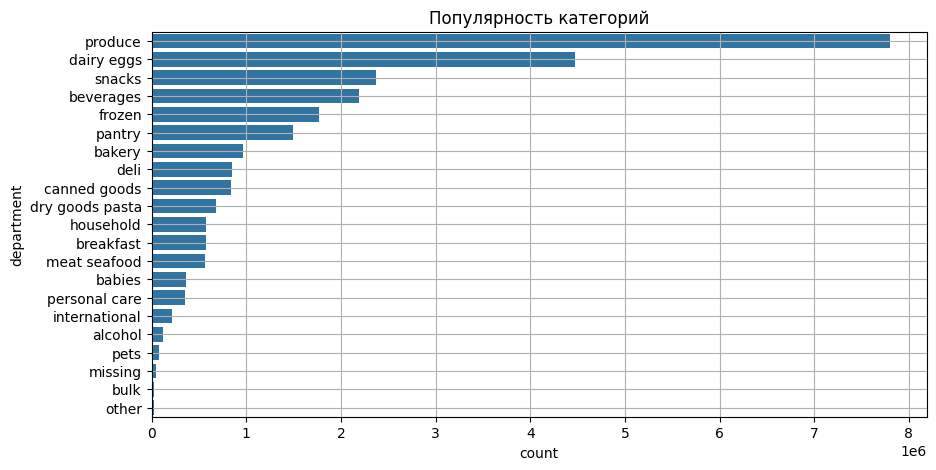

In [16]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(data=top_department, y='department', x='count')
plt.title('Популярность категорий')
plt.grid()
plt.show()

In [17]:
# Популярные категории
top_aisle = (
    detailed_popular_products_df
        .groupby(['aisle_id', 'aisle'], as_index=False)
        ['count'].sum()
        .sort_values(by='count', ascending=False)

)
top_aisle.head(10)

,aisle_id,aisle,count
23,24,fresh fruits,3038128
82,83,fresh vegetables,2781317
122,123,packaged vegetables fruits,1447548
119,120,yogurt,1209943
20,21,packaged cheese,796375
83,84,milk,752932
114,115,water seltzer sparkling water,690691
106,107,chips pretzels,584428
90,91,soy lactosefree,527901
111,112,bread,479256


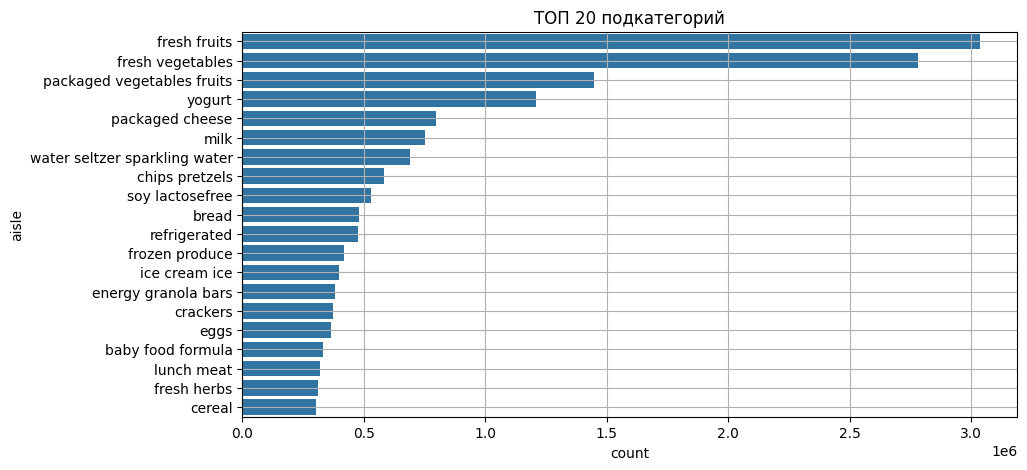

In [18]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(data=top_aisle.head(20), y='aisle', x='count')
# ax.tick_params(axis='x', rotation=45)
plt.title('ТОП 20 подкатегорий')
plt.grid()
# plt.xticks(rotation=-45)
plt.show()

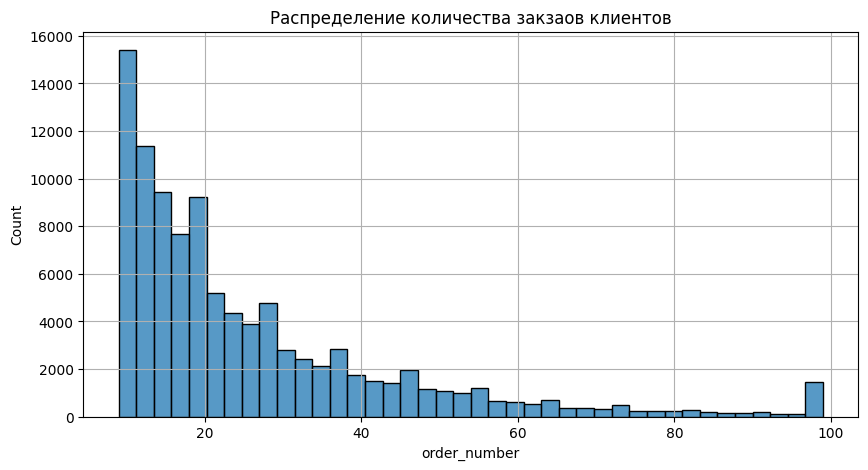

In [19]:
plt.figure(figsize=(10, 5))
sns.histplot(data = transaction_df.groupby(['user_id'])['order_number'].max(),
             bins=40)
plt.title('Распределение количества закзаов клиентов')
plt.grid()
plt.show()

In [20]:
# Количество продукто в каждом заказе клиента 
products_on_order = (
    transaction_df
        .groupby(['user_id', 'order_number'], as_index=False)['add_to_cart_order']
        .max())

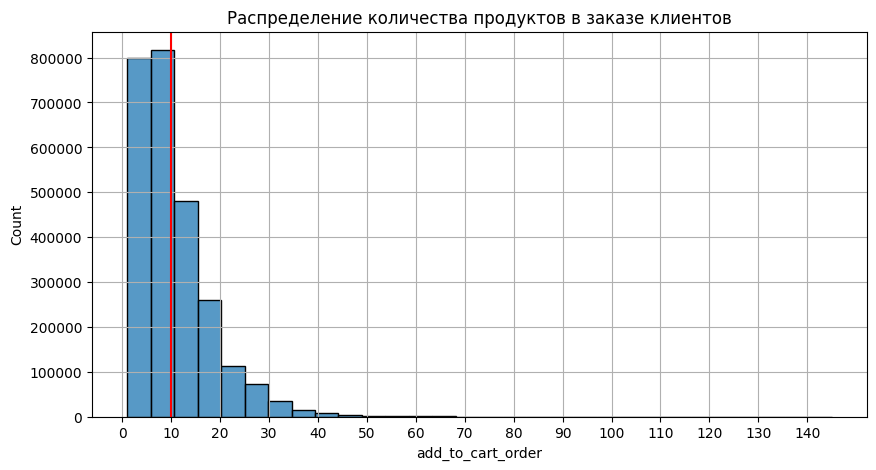

In [21]:
plt.figure(figsize=(10, 5))
sns.histplot(data = products_on_order['add_to_cart_order'],
             bins=30)
plt.title('Распределение количества продуктов в заказе клиентов')
plt.axvline(x=10, ymin=0, ymax=1, c='r')
plt.xticks([i for i in range(0, 141, 10)])
plt.grid()
plt.show()

In [22]:
# Среднее количество продуктов в заказе клиента
avg_count_products_on_client_order = (
        products_on_order
                .groupby(['user_id'], as_index=False)['add_to_cart_order']
                .mean())

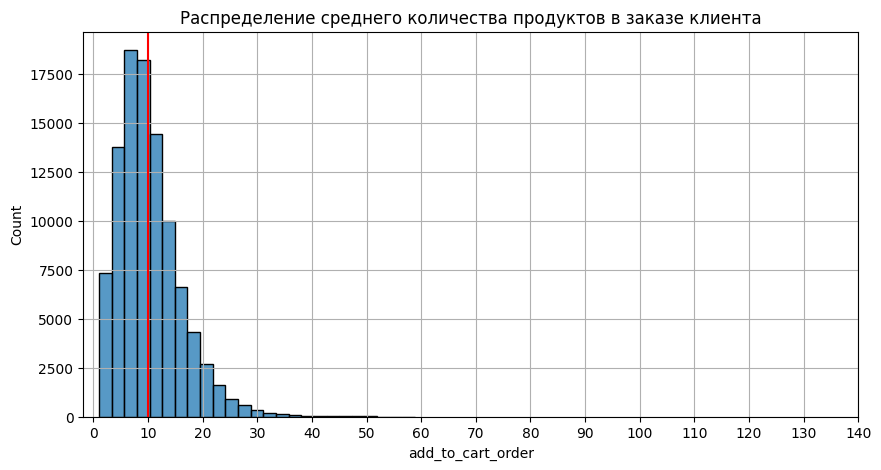

In [23]:
plt.figure(figsize=(10, 5))
sns.histplot(data = avg_count_products_on_client_order['add_to_cart_order'],
             bins=25)
plt.title('Распределение среднего количества продуктов в заказе клиента')
plt.axvline(x=10, ymin=0, ymax=1, c='r')
plt.xticks([i for i in range(0, 141, 10)])
plt.grid()
plt.show()

Из распределений количества продуктов видно, что модальное количество продуктов в заказе 9-10 единиц продукции.</br>
Следовательно, для данного магазина целесообразно представлять персонализированную рекомендацию в виде предложения 10 товаров. 

<b>Подготовка данных</b>

In [24]:
# Минимальное число заказов для клиента
min_orders = min(transaction_df.groupby(['user_id'])['order_number'].nunique())
print(f'Минимальное число заказов на одного клиента в обучающей выборке = {min_orders}')

Минимальное число заказов на одного клиента в обучающей выборке = 9


Разделение данных на train и test так, чтобы в test попали последние заказы клиентов. 

In [25]:
def train_test_split(transaction_df: pd.DataFrame):
    # Перечень заказов пользователей, которые попадут в test
    test_orders_df = transaction_df.groupby(['user_id'], as_index=False)['order_number'].max()
    # Сохранение исходных индексов
    transaction_df = transaction_df.reset_index()
    test_transaction_df = transaction_df.merge(test_orders_df, on=['user_id', 'order_number'], how='inner')
    # Исключаем транзакции, которые попали в test
    train_transaction_df = transaction_df[~transaction_df['index'].isin(test_transaction_df['index'])]
    # Удаление полей с значением исходных индексов
    train_transaction_df = train_transaction_df.drop(columns='index')
    test_transaction_df = test_transaction_df.drop(columns='index')

    return train_transaction_df, test_transaction_df

In [26]:
# Разделение данных 
train_transaction_df, test_transacrion_df = train_test_split(transaction_df=transaction_df)
# Проверка размерноестей
assert len(train_transaction_df) + len(test_transacrion_df) == len(transaction_df)

In [28]:
# Сохранение данных
test_transacrion_df.to_csv('test_transacrion_df.csv')

Расчет рейтинга 
r - доля вхождений единиц товара во все заказа = количество кхождений в заказ товара / количество заказов 

In [27]:
# Расчет количества вхождений продуктов в заказ и количество заказов
count_product_ordered = (
    train_transaction_df.groupby(['user_id', 'product_id'], as_index=False)
        ['reordered'].count())
count_order_by_user = (
    train_transaction_df.groupby(['user_id'], as_index=False)
    ['order_number'].max())

In [29]:
# Расчет рейтинга
rating_df = count_product_ordered.merge(count_order_by_user, on='user_id', how='left')
rating_df['rating'] = rating_df['reordered']/rating_df['order_number']
rating_df = rating_df.drop(columns=['reordered', 'order_number'])
# Сокращение объема данных
rating_df['user_id'] = pd.to_numeric(rating_df['user_id'], downcast='integer')
rating_df['product_id'] = pd.to_numeric(rating_df['product_id'], downcast='integer')
# Сокращение объема данных
rating_df['rating'] = pd.to_numeric(rating_df['rating'], downcast='float')

In [30]:
rating_df[rating_df['user_id'] == 1]

,user_id,product_id,rating
0,1,196,1.000000
1,1,10258,0.888889
2,1,10326,0.111111
3,1,12427,1.000000
4,1,13032,0.222222
5,1,13176,0.222222
6,1,14084,0.111111
7,1,17122,0.111111
8,1,25133,0.777778
9,1,26088,0.222222


## Формирование матриц 

In [31]:
def make_sparse(dataset: pd.DataFrame) -> sps.csr_matrix:
    shape =  len(dataset["user_id"]), len(dataset["product_id"])
    values = dataset["rating"].to_numpy()
    return sps.csr_matrix(
        (values, (dataset["user_id"].to_numpy(), dataset["product_id"].to_numpy())), shape=shape)

In [34]:
rating_matrix = make_sparse(dataset=rating_df)

In [35]:
print(rating_matrix[1])

  (0, 196)	1.0
  (0, 10258)	0.8888889
  (0, 10326)	0.11111111
  (0, 12427)	1.0
  (0, 13032)	0.22222222
  (0, 13176)	0.22222222
  (0, 14084)	0.11111111
  (0, 17122)	0.11111111
  (0, 25133)	0.7777778
  (0, 26088)	0.22222222
  (0, 26405)	0.22222222
  (0, 30450)	0.11111111
  (0, 41787)	0.11111111
  (0, 46149)	0.22222222
  (0, 49235)	0.22222222


In [36]:
# Сохранение матрицы
sps.save_npz('rating_matrix.npz', rating_matrix)